**MLP классификатор** 

Евгений Борисов  <esborisov@sevsu.ru>

In [1]:
import numpy as np
from numpy import random as rng
import matplotlib.pyplot as plt

In [2]:
np.set_printoptions(precision=2)

## генерируем данные

In [3]:
n_samples = 1500

# from sklearn.datasets import make_blobs
# X,target = make_blobs( n_samples=n_samples, centers=2,  cluster_std=[1.5, 1.8,] )

# from sklearn.datasets import make_moons
# X,target = make_moons(n_samples=n_samples, noise=.09)

from sklearn.datasets import make_circles
X,target = make_circles(n_samples=n_samples, shuffle=True, noise=.09, factor=.3)
# X = X+(np.random.rand(X.shape[0],X.shape[1])*0.6)


y = np.eye(len(target),2)[target] # [:,np.newaxis]

X.shape, y.shape

((1500, 2), (1500, 2))

In [4]:
# help(make_classification)

In [5]:
# from sklearn.datasets import make_classification
# X, target = make_classification(
#     n_samples=n_samples,
#     n_features=2,
#     n_classes=2,
#     n_informative=1,
#     n_redundant=1,
#     n_clusters_per_class=1,
#     scale=2.,
#     # hypercube=True,
# #     flip_y=5.1
# )

# y = np.eye(len(target),2)[target] # [:,np.newaxis]

# X.shape, y.shape

In [6]:
# нормируем данные
# from sklearn.preprocessing import MinMaxScaler
# X = MinMaxScaler([-1.0,1.0]).fit_transform(X)

# from sklearn.preprocessing   import StandardScaler
# X = StandardScaler().fit(X).transform(X)

In [7]:
# np.percentile(X,[10,25,50,75,95],axis=0) 

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.5)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((750, 2), (750, 2), (750, 2), (750, 2))

In [9]:
del X
del y
del target

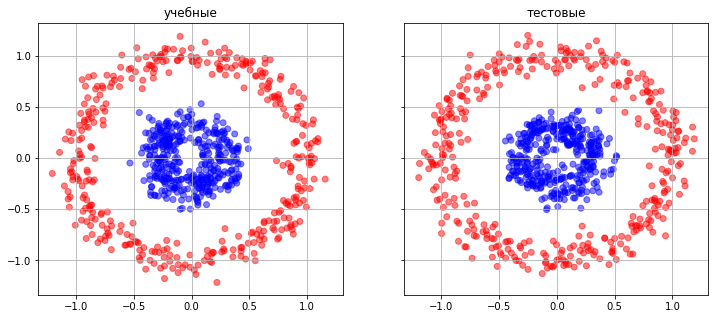

In [10]:
def plot_data(ax,X,y,t):
    c = [ ['b','r','g','y'][j] for j in y.astype(int).flatten()  ]
    ax.set_title(t)
    ax.scatter( x=X[:,0], y=X[:,1], c=c,  alpha=0.5 )
    ax.grid()

fig, (ax0,ax1) = plt.subplots(1,2, sharey=True, sharex=True, figsize=(12,5),)
plot_data(ax0,X_train,y_train[:,0],'учебные')    
plot_data(ax1,X_test,y_test[:,0],'тестовые')    
plt.show()

## модель

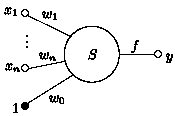

In [11]:
def dense(x,w,b): # состояние нейронов слоя
    return x.dot(w) + b

In [12]:
# def dense_partial(x,w,b): 
#     return x

In [13]:
def sigmoid(u): # функция активации
    return 1./(1. + np.exp(-u))

# act = sigmoid

In [14]:
def d_sigmoid(u): # производная активации
    return ( np.square(sigmoid(u))*np.exp(-u) )
# diff_act = diff_sigmoid

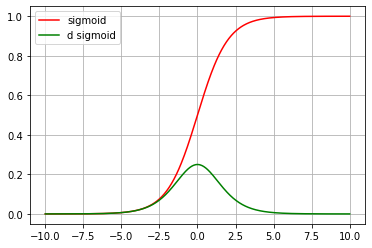

In [15]:
u=np.linspace(-10,10,500)
plt.plot( u,sigmoid(u),'-r', label='sigmoid' )
plt.plot( u,d_sigmoid(u),'-g', label='d sigmoid' )
plt.grid()
plt.legend()

In [16]:
def layer(x,l): # выход слоя
    return l['activate']( l['state']( x, l['weight'], l['bias'] ) )

---

In [17]:
def model_init(model):
    for i in range(len(model)-1):
        model[i+1]['weight'] = rng.normal(size=(model[i]['size'],model[i+1]['size']),scale=.1)   
        model[i+1]['bias'] = rng.normal(size=(1,model[i+1]['size']),scale=.1)  
    return model[1:]

In [18]:
model = [
{ # input
    'size':X_train.shape[1],
},
{ # hidden layer 1
    'state': dense,
    'size': 10,
    'activate': sigmoid,
    'd_activate': d_sigmoid,
#     'd_state': dense_partial,
    
},
{ # output
    'state': dense,
    'size': y_train.shape[1],     
    'activate': sigmoid,
    'd_activate': d_sigmoid,
#     'd_state': dense_partial,
},     
]

In [19]:
model = model_init(model)

[ [ l['weight'].shape,l['bias'].shape] for l in model ]

[[(2, 10), (1, 10)], [(10, 2), (1, 2)]]

In [20]:
def score(x,model):
    o = x
    for l in model:
        o = layer(o,l)
    return o

In [21]:
score(X_train,model).shape

(750, 2)

## обучаем модель

функция потери средняя квадратичная ошибка
$$L=MSQE(y,o)=\frac{1}{m}\sum\limits_{i=0}^m(o_i-y_i)^2$$

In [22]:
def msqe(y,o): # средняя квадратичная ошибка
    d = o-y 
    return np.square(d).sum()/(len(y)*y.shape[1])

loss = msqe

In [23]:
msqe(y_train,score(X_train,model))

0.25029660022211925

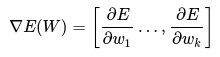

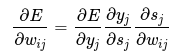

частные производные функции потери по параметрам модели (градиент)

$$ \frac{\partial E }{\partial w} = 2 \cdot( o - y ) \cdot \frac{\partial o }{\partial w}  $$

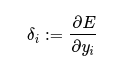

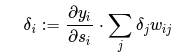

In [24]:
def forward(x,model):
    state = []
    o = x
    for l in model:
        s = l['state']( o, l['weight'], l['bias'] )
        o = l['activate']( s )
        state.append(s)
    return state 

# [ s.shape for s in forward(X_train,model) ][::-1]

def backward(d_output,state,model):
    delta = [ d_output ]
    d = d_output
    for s,l in zip( 
        state[-2::-1], # выкинуть последний, список в обратном порядке
        model[:0:-1]  # выкинуть первый, список в обратном порядке
    ):
        d = l['d_activate'](s)*d.dot(l['weight'].T)
        delta.append(d)
    return delta[::-1]        


def msqe_partial(x,model,y): # градиент функции потери,
    state = forward(x,model)
    delta = backward( score(x,model)-y, state, model)
    output = [x]+[ l['activate'](s) for s,l in zip(state,model) ]

    d_weight = [ 
        { 
            'weight': x.T.dot(d),
              'bias': d.sum(axis=0,keepdims=True),
        }
        for x,d in zip(output[:-1],delta) 
        ]

    w_max = max([ 
        max(  np.abs(l['weight']).max(), np.abs(l['bias']).max(),  ) 
        for l in d_weight
    ])
    
    if w_max>0.:
        d_weight = [{ 
                'weight': l['weight']/w_max ,
                  'bias': l['bias']/w_max
            } 
            for l in d_weight
        ]

    return d_weight


gradient = msqe_partial

# msqe_partial(X_train,model,y_train)

In [25]:
# # градиент
# def grad(X,L,E):
#     GW = [ X.T.dot(E[0]) ] # градиент по весам скрытого слоя
#     GS = [ E[0].sum(axis=0) ] # градиент по сдвигам скрытого слоя

#     O1 = act1(L[0]) # выход скрытого слоя
#     GW.append( O1.T.dot(E[1]) ) # градиент по весам выходного слоя
#     GS.append( E[1].sum(axis=0) ) # градиент по сдвигам выходного слоя

#     O2 = act2(L[1]) # выход скрытого слоя
#     GW.append( O2.T.dot(E[2]) ) # градиент по весам выходного слоя
#     GS.append( E[2].sum(axis=0) ) # градиент по сдвигам выходного слоя

#     return GW,GS    
    
# # # градиент
# # def grad(X,L,E):
# #     GW = [ X.T.dot(E[0]) ] # градиент по весам скрытого слоя
# #     GS = [ E[0].sum(axis=0) ] # градиент по сдвигам скрытого слоя

# #     O = act(L[0]) # выход скрытого слоя
# #     GW.append( O.T.dot(E[1]) ) # градиент по весам выходного слоя
# #     GS.append( E[1].sum(axis=0) ) # градиент по сдвигам выходного слоя

# #     return GW,GS    

In [26]:
# % - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
# function retval=mlp_grad(l,er,cfg),
#    ltp = 2 ; % номер ячейки cfg с типом ф-ции активации
#    g = {} ; % градиент ошибки сети
   
#    for j=1:length(er),
#       o = mlp_activate(l{j},cfg{j}{ltp})  ;
# 	  g{j}{1} = er{j}*o' ; 
# 	  g{j}{2} = sum(er{j},2) ;
#    endfor


#    retval=g;

# endfunction

# % - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
# function retval=mlp_errors(l,y,W,cfg),
#    ltp=2; % номер ячейки cfg с типом ф-ции активации
#    layers_numb = length(cfg) ; % количество слоёв сети, включая вход
 
#    er = {} ; % ошибка слоёв
  
#    er{layers_numb-1} = mlp_loss_drvt( l{end}, y, cfg ) ; % ошибка сети (выходного слоя)
  
#    for j=layers_numb-2:-1:1, % ошибки скрытых слоёв
# 	  df = mlp_activate_drvt( l{j+1}, cfg{j+1}{ltp} ) ; % значения производной ф-ции активации 
# 	  er{j} = ( (W{j+1}{1})' * er{j+1} ) .* df ; % ошибка слоя j
#    endfor

#    retval=er;
# endfunction


In [27]:
# [ [a,b,c] for a,b,c in zip([1,2,3],[4,5,6],[7,8,9]) ]

In [28]:
# rng.normal(size=3).amax

---

In [29]:
# корректируем параметры
def weight_adjust(model,d_weight,lr):
    for l,d in zip(model,d_weight):
        l['weight'] -= lr*d['weight']
        l['bias'] -= lr*d['bias']

In [30]:
def fit_epoch(x,model,y,lr): # шаг обучения модели
    d_weight = gradient(x,model,y) # градиент функции потери, изменение весов
    return weight_adjust(model,d_weight,lr) # корректируем параметры

In [31]:
from sklearn.metrics import accuracy_score

In [32]:
# инициализация параметров модели
# W = init_weight(model_size)

In [68]:
%%time

# метод градиентного спуска

lr = 1e-3 # скорость обучени
n_samples = len(y_train) # количество примеров
n_epoch = 20 # максимальное число циклов обучения
acc_min = .98 # порог минимально допустимой погрешности модели
n_param = X_train.shape[1] # размер вектора признаков

# начальное значение ф-ции потери
loss_history = [ loss(y_train,score(X_train,model)) ]
acc_history = [ accuracy_score( y_train[:,1].astype(int), (score(X_train,model)[:,1]>.5).astype(int) ) ]

for i in range(n_epoch): # цикл обучения
    W = fit_epoch(X_train,model,y_train,lr) # корректируем веса модели
    loss_history.append( loss(y_train,score(X_train,model)) ) # считаем значение ф-ции потери
    acc_history.append( accuracy_score( y_train[:,1].astype(int) , (score(X_train,model)[:,1]>.5).astype(int) ) )
    
    if acc_history[-1] > acc_min: # проверяем достижение минимального порога погрешности модели
        print('step %i/%i: loss %.03f, acc threshold %.03f reached\n'%(i+1,n_epoch,loss_history[-1],acc_min))
        break

CPU times: user 35.8 ms, sys: 0 ns, total: 35.8 ms
Wall time: 35 ms


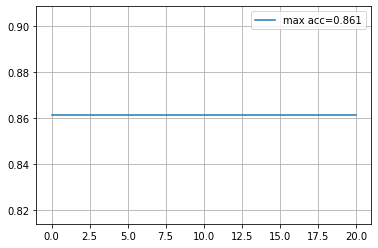

In [69]:
# история изменения значений погрешности модели
plt.plot(acc_history,label='max acc=%.3f'%(max(acc_history)))
plt.grid()
plt.legend()

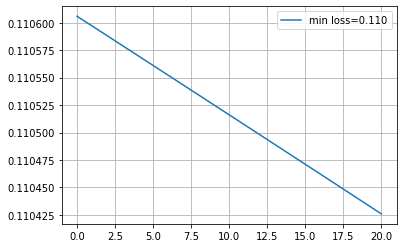

In [70]:
# история изменения значений ф-ции потери
plt.plot(loss_history,label='min loss=%.3f'%(min(loss_history)))
plt.grid()
plt.legend()

In [48]:
# W

## тестируем модель

In [49]:
s = score(X_test,model)[:,1]

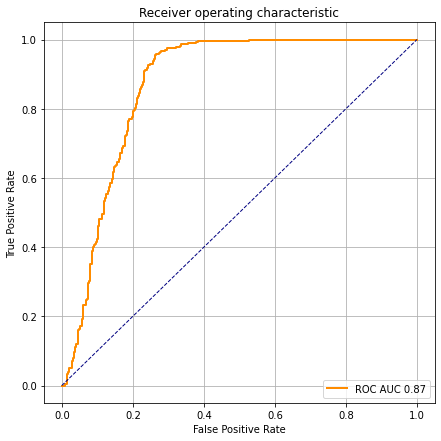

In [50]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

fpr, tpr, thresholds = roc_curve( y_test[:,1], s )
roc_auc = auc(fpr,tpr)

plt.figure(figsize=(7,7))
plt.grid(True)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC AUC %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [51]:
# оптимальный порого скора 
#  максимальное количество True Positive при минимальном количестве False Positive
optimal_threshold = thresholds[ np.argmax( np.abs(tpr-fpr) )  ]
optimal_threshold

0.5776707132388047

In [52]:
p = (s>optimal_threshold).astype(int)
y = y_test[:,1].astype(int)

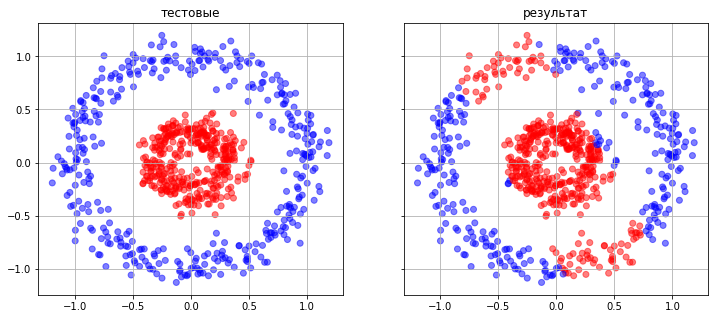

In [53]:
fig, (ax0,ax1) = plt.subplots(1,2, sharey=True, sharex=True, figsize=(12,5),)
plot_data(ax0,X_test,y,'тестовые')    
plot_data(ax1,X_test,p,'результат')    
plt.show()

In [42]:
from sklearn.metrics import classification_report
print(classification_report(y,p))

              precision    recall  f1-score   support

           0       0.39      0.63      0.49       378
           1       0.01      0.01      0.01       372

    accuracy                           0.32       750
   macro avg       0.20      0.32      0.25       750
weighted avg       0.21      0.32      0.25       750



## карта скоров

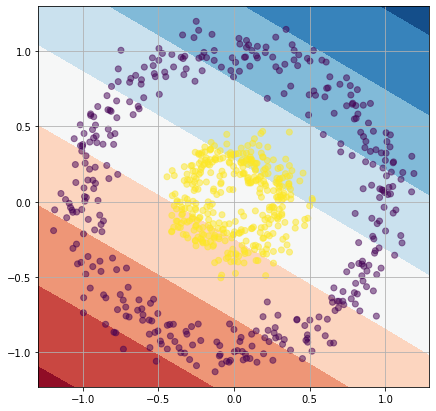

In [43]:
# строим сетку и определяем значения скора классификатора во всех узлах

n=500 # количество разбиений сетки

xx,yy = np.meshgrid(
    np.linspace( X_test[:,0].min()-.1, X_test[:,0].max()+.1, n), 
    np.linspace( X_test[:,1].min()-.1, X_test[:,1].max()+.1, n)
) # узлы сетки

xy = np.vstack([xx.flatten(),yy.flatten() ]).T # разворачиваем сетку 

s = score(xy,model)[:,1]

plt.figure(figsize=(7,7))
plt.contourf(xx, yy, (1.-s).reshape(n,n), cmap=plt.cm.RdBu)
plt.scatter( x=X_test[:,0], y=X_test[:,1], c=y_test[:,1].astype(int), alpha=.5 )
plt.grid()

In [44]:
# import graphviz
# dot = graphviz.Digraph()
# dot.attr(size='6,7')

# layer = []
# l=0
# for n in range(model_size[0]):
#     node=f'{l}-{n}'
#     dot.node(node,f'{n}')
#     layer.append(node)

# for l,s in enumerate(model_size[1:],1):
#     layer_prev = layer.copy()
#     layer=[]
#     for n in range(s):
#         node=f'{l}-{n}'
#         dot.node(node,f'{n}')
#         for lp in layer_prev: dot.edge(lp,node)        
#         layer.append(node)

# dot        